In [1]:
# Load packages
import pandas as pd
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import numpy as np
import numpy.matlib as matlib
import glob
import calendar
import pymannkendall as mk
import regionmask
import cmasher as cmr

# Ignore NaN errors - don't affect calculations
import warnings
warnings.simplefilter('ignore', RuntimeWarning)

In [2]:
# Define seasonal rainfall periods for May-October Growing Season and bi-monthly sub-periods
def is_GS(month):
    return (month >= 5) & (month <= 10)

def is_MJ(month):
    return (month >= 5) & (month <= 6)

def is_JA(month):
    return (month >= 7) & (month <= 8)

def is_SO(month):
    return (month >= 9) & (month <= 10)

In [3]:
## Calculations on observational data 
fname = '/glade/work/tanderson/GPCC/gpcc_05_v2020.nc'

#Load GPCC obs
dset_obs = xr.open_mfdataset(fname)
dset_obs = dset_obs.sel(lat=slice(18,11), lon=slice(-93,-83), time=slice('1920-01-01','2019-12-01')) # slice data to lat and lons of interest

# Set units and get time
dset_obs.attrs['units'] = 'mm/month'
dset_obs_year = dset_obs['time.year']
dset_obs_month = dset_obs['time.month']

# Make a regional land mask to remove any ocean area
land = regionmask.defined_regions.natural_earth_v5_0_0.land_10.mask(dset_obs)

# Mask precip observations
obsLand = dset_obs.where(land==0).load()

 # Get annual precip total 
annObs = obsLand.groupby('time.year').sum('time', skipna=False, keep_attrs=True) 
    
# Get annual growing season rainfall totals
GSObs = obsLand.sel(time=is_GS(obsLand['time.month']))
GSObs = GSObs.groupby('time.year').sum('time', skipna=False, keep_attrs=True) 

# Get bi-monthly totals    
JAObs = obsLand.sel(time=is_JA(obsLand['time.month']))
JAObs = JAObs.groupby('time.year').sum('time', skipna=False, keep_attrs=True) 

MJObs = obsLand.sel(time=is_MJ(obsLand['time.month']))
MJObs = MJObs.groupby('time.year').sum('time', skipna=False, keep_attrs=True) 
    
SOObs = obsLand.sel(time=is_SO(obsLand['time.month']))
SOObs = SOObs.groupby('time.year').sum('time', skipna=False, keep_attrs=True)   
 
# Calculate % of annual rainfall in each season (seasonal/annual*100)
GSpercObs = np.divide(GSObs,annObs)*100
MJpercObs = np.divide(MJObs,annObs)*100
JApercObs = np.divide(JAObs,annObs)*100
SOpercObs = np.divide(SOObs,annObs)*100

# Get average annual % of rainfall that occurs in growing season
avgGSpercObs = GSpercObs.mean('year', keep_attrs=True)
    
# Get mean seasonal precip
meanGSObs = GSObs.mean('year', keep_attrs=True)
meanMJObs = MJObs.mean('year', keep_attrs=True)
meanJAObs = JAObs.mean('year', keep_attrs=True)
meanSOObs = SOObs.mean('year', keep_attrs=True)
    
# Get annual anomalies of % of normal seasonal rainfall (annual observation totals/mean seasonal total)
GSanomPObs = np.divide(GSObs,meanGSObs)*100-100
MJanomPObs = np.divide(MJObs,meanMJObs)*100-100
JAanomPObs = np.divide(JAObs,meanJAObs)*100-100
SOanomPObs = np.divide(SOObs,meanSOObs)*100-100

# Mask where annual growing season rainfall <75% of annual
GSanomPObs = GSanomPObs.where(avgGSpercObs>75)
MJanomPObs = MJanomPObs.where(avgGSpercObs>75)
JAanomPObs = JAanomPObs.where(avgGSpercObs>75)
SOanomPObs = SOanomPObs.where(avgGSpercObs>75)

#Take regional mean
regTS_GSObs = GSanomPObs.mean(['lat','lon'])
regTS_MJObs = MJanomPObs.mean(['lat','lon'])
regTS_JAObs = JAanomPObs.mean(['lat','lon'])
regTS_SOObs = SOanomPObs.mean(['lat','lon'])
    
# Get 5 year moving mean for region
reg5mov_GSObs = regTS_GSObs.rolling(year=5).mean()
reg5mov_MJObs = regTS_MJObs.rolling(year=5).mean()
reg5mov_JAObs = regTS_JAObs.rolling(year=5).mean()
reg5mov_SOObs = regTS_SOObs.rolling(year=5).mean()

In [4]:
# Get 2015-2019 obs 5 year means
print(reg5mov_GSObs.precip.values[-1])
print(reg5mov_JAObs.precip.values[-1])

-11.48787612915039
-27.638134765625


In [5]:
# Select 2015-2019 for each season for spatial plotting
GSObsDrought = GSanomPObs.sel(year=slice(2015, 2019))
GSObsDrought = GSObsDrought.mean(['year'])

MJObsDrought = MJanomPObs.sel(year=slice(2015, 2019))
MJObsDrought = MJObsDrought.mean(['year'])

JAObsDrought = JAanomPObs.sel(year=slice(2015, 2019))
JAObsDrought = JAObsDrought.mean(['year'])

SOObsDrought = SOanomPObs.sel(year=slice(2015, 2019))
SOObsDrought = SOObsDrought.mean(['year'])

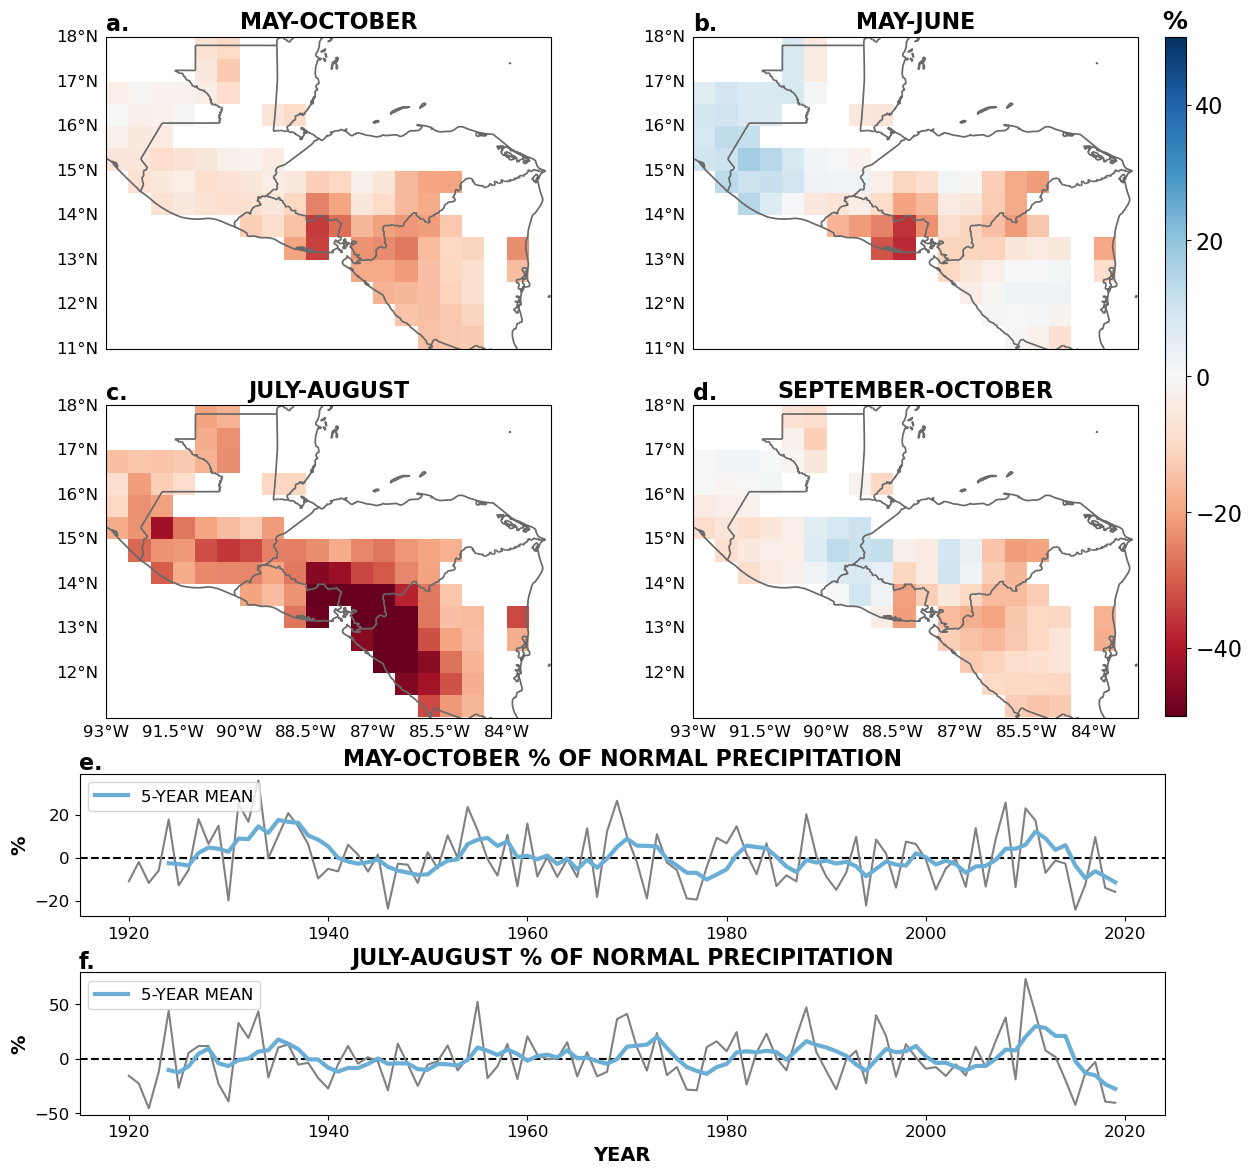

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [6]:
# Plot monthly time series with maps
cmap = mpl.colormaps['Blues']
blu = cmap(0.5)

# define scale, with white at zero
vmin = -50 
vmax = 50
norm = mpl.colors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

fig = plt.figure(figsize=[14,14])
ax1 = plt.subplot2grid(shape=(39,12),loc=(0,0),rowspan = 12, colspan=6, projection=ccrs.PlateCarree(central_longitude = 0.0))
plt1 = GSObsDrought.precip.plot(ax=ax1, extend='max', cmap='RdBu',
                    transform=ccrs.PlateCarree(), add_colorbar = False, vmin=vmin, vmax=vmax, norm=norm)
ax1.set_extent([-93.01, -82.99, 10.99, 18.01])
ax1.add_feature(cf.COASTLINE,edgecolor='dimgray',linewidth=1.25)
ax1.add_feature(cf.BORDERS,edgecolor='dimgray',linewidth=1.25)
ax1.set_title(f'MAY-OCTOBER', y=1, fontweight = 'bold', fontsize=16)
ax1.text(-93, 18.15, 'a.',fontsize=16,fontweight='bold')
gl = ax1.gridlines(draw_labels=True)
gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12}
gl.xlines = False
gl.ylines = False
gl.top_labels = False
gl.right_labels = False
gl.bottom_labels = False

ax2 = plt.subplot2grid(shape=(39,12),loc=(0,6),rowspan = 12, colspan=6, projection=ccrs.PlateCarree(central_longitude = 0.0))
plt1 = MJObsDrought.precip.plot(ax=ax2, extend='max', cmap='RdBu',
                    transform=ccrs.PlateCarree(), add_colorbar = False,vmin=vmin, vmax=vmax, norm=norm)
ax2.set_extent([-93.01, -82.99, 10.99, 18.01])
ax2.add_feature(cf.COASTLINE,edgecolor='dimgray',linewidth=1.25)
ax2.add_feature(cf.BORDERS,edgecolor='dimgray',linewidth=1.25)
ax2.set_title(f'MAY-JUNE', y=1, fontweight = 'bold', fontsize=16)
ax2.text(-93, 18.15, 'b.',fontsize=16,fontweight='bold')
gl = ax2.gridlines(draw_labels=True)
gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12}
gl.xlines = False
gl.ylines = False
gl.top_labels = False
gl.right_labels = False
gl.bottom_labels = False

ax3 = plt.subplot2grid((39,12),(13,0),rowspan = 12, colspan=6, projection=ccrs.PlateCarree(central_longitude = 0.0))
plt1 = JAObsDrought.precip.plot(ax=ax3, extend='max', cmap='RdBu',
                    transform=ccrs.PlateCarree(), add_colorbar = False,vmin=vmin, vmax=vmax, norm=norm)
ax3.set_extent([-93.01, -82.99, 10.99, 18.01])
ax3.add_feature(cf.COASTLINE,edgecolor='dimgray',linewidth=1.25)
ax3.add_feature(cf.BORDERS,edgecolor='dimgray',linewidth=1.25)
ax3.set_title(f'JULY-AUGUST', y=1, fontweight = 'bold', fontsize=16)
ax3.text(-93, 18.15, 'c.',fontsize=16,fontweight='bold')
gl = ax3.gridlines(draw_labels=True)
gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12}
gl.xlines = False
gl.ylines = False
gl.top_labels = False
gl.right_labels = False

ax4 = plt.subplot2grid((39,12),(13,6),rowspan = 12, colspan=6, projection=ccrs.PlateCarree(central_longitude = 0.0))
plt1 = SOObsDrought.precip.plot(ax=ax4, extend='max', cmap='RdBu',
                    transform=ccrs.PlateCarree(), add_colorbar = False,vmin=vmin, vmax=vmax, norm=norm)
ax4.set_extent([-93.01, -82.99, 10.99, 18.01])
ax4.add_feature(cf.COASTLINE,edgecolor='dimgray',linewidth=1.25)
ax4.add_feature(cf.BORDERS,edgecolor='dimgray',linewidth=1.25)
ax4.set_title(f'SEPTEMBER-OCTOBER', y=1,fontweight = 'bold', fontsize=16)
ax4.text(-93, 18.15, 'd.',fontsize=16,fontweight='bold')
gl = ax4.gridlines(draw_labels=True)
gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12}
gl.xlines = False
gl.ylines = False
gl.top_labels = False
gl.right_labels = False

ax5 = plt.subplot2grid((39,12),(26,0),rowspan = 6, colspan=12)
plt.axhline(0,color = 'black', linestyle = '--')
ax5.plot(regTS_GSObs.year, regTS_GSObs.precip,color="grey")
ax5.axvspan(2015, 2019, color="grey", alpha=0.2)
yr5lineGS, = ax5.plot(reg5mov_GSObs.year, reg5mov_GSObs.precip,color=blu,linewidth=3.0, label="5-YEAR MEAN")
ax5.text(1915, 41, 'e.',fontsize=16,fontweight='bold')
ax5.legend(handles=[yr5lineGS], fontsize=12, loc='upper left')
ax5.set_ylabel(f'%',fontweight = 'bold', fontsize=14)
ax5.tick_params(axis='both', which='major', labelsize=12)
ax5.set_title(f'MAY-OCTOBER % OF NORMAL PRECIPITATION', fontweight = 'bold', fontsize=16)

ax6 = plt.subplot2grid((39,12),(33,0),rowspan = 6, colspan=12)
plt.axhline(0,color = 'black', linestyle = '--')
ax6.plot(regTS_JAObs.year, regTS_JAObs.precip,color="grey")
ax6.axvspan(2015, 2019, color="grey", alpha=0.2)
yr5lineJA, = ax6.plot(reg5mov_JAObs.year, reg5mov_JAObs.precip,color=blu,linewidth=3.0,label="5-YEAR MEAN")
ax6.text(1915, 83, 'f.',fontsize=16,fontweight='bold')
ax6.legend(handles=[yr5lineJA], fontsize=12,loc='upper left')
ax6.set_xlabel(f'YEAR',fontweight = 'bold', fontsize=14)
ax6.set_ylabel(f'%',fontweight = 'bold', fontsize=14)
ax6.tick_params(axis='both', which='major', labelsize=12)
ax6.set_title(f'JULY-AUGUST % OF NORMAL PRECIPITATION', fontweight = 'bold', fontsize=16)

# Add a colorbar axis on the right of the figure
cbar_ax = fig.add_axes([.90, 0.395, 0.015, 0.485])

# Draw the colorbar
cbar=fig.colorbar(plt1, cax=cbar_ax,orientation='vertical')
cbar.ax.set_title(label='%', weight='bold',fontsize=18)
cbar.ax.tick_params(labelsize=16)

#fig.tight_layout()
fig.subplots_adjust(hspace=60, wspace=10)
plt.show()
fig.savefig('/glade/work/tanderson/DC_Drought/Figures/DroughtMaps2015_2019_TimeSeries.pdf', format='pdf', bbox_inches='tight')

In [7]:
# OLENS ANALYSIS

# Make directories for saving if running for the first time
#os.mkdir('/glade/scratch/tanderson/obsLEAnalysis/GStotals_v-noF_CLLJV2_v02_CentAm_Pr_05deg_blockNew/')
#os.mkdir('/glade/scratch/tanderson/obsLEAnalysis/JAtotals_v-noF_CLLJV2_v02_CentAm_Pr_05deg_blockNew/')
#os.mkdir('/glade/scratch/tanderson/obsLEAnalysis/GS5yr_v-noF_CLLJV2_v02_CentAm_Pr_05deg_blockNew/')
#os.mkdir('/glade/scratch/tanderson/obsLEAnalysis/JA5yr_v-noF_CLLJV2_v02_CentAm_Pr_05deg_blockNew/')

# Set up empty arrays
n_ens_mems = 1000
memTS_GS = np.empty((100, n_ens_mems))
memTS_JA = np.empty((100, n_ens_mems))

memTS_GS_5yr = np.empty((100, n_ens_mems))
memTS_JA_5yr = np.empty((100, n_ens_mems))

# All file names
fnames = sorted(glob.glob('/glade/scratch/tanderson/obsLE/output_v-noF_CLLJV2_v02_CentAm_Pr_05deg_blockNew/obs/pr/pr_member????.nc'))

# Open one file for set up
dset_pre = xr.open_mfdataset(fnames[0])
dset_pre = dset_pre.sel(lat=slice(18,11), lon=slice(-93,-83)) # slice data to lat and lons of interest

# Set units and get time
dset_pre.attrs['units'] = 'mm/day'
dset_year = dset_pre['time.year']
dset_month = dset_pre['time.month']

# Get days per month for each year/month since OLE data is saved in mm/day
days_per_month = [calendar.monthrange(int(y), int(m))[1] for y, m in zip(dset_year, dset_month)]

# Create 3-d days/per month to multiply files by
days_per_month = np.tile(days_per_month, (len(dset_pre.lat), len(dset_pre.lon),1))
days_per_month = np.transpose(days_per_month,(2, 0, 1)) 

# Make a regional mask
landOle = regionmask.defined_regions.natural_earth_v5_0_0.land_10.mask(dset_pre)

# Precip Masked
oleLand = dset_pre.where(landOle==0).load()

for i in range(0,len(fnames)):
    dset = xr.open_mfdataset(fnames[i])
    pr = dset.pr
    pr = pr.sel(lat=slice(18,11), lon=slice(-93,-83)) # slice data to lat and lons of interest
    prLand = pr.where(landOle==0).load() # mask file 
    prLandMask = prLand.where(avgGSpercObs>75) # mask with same as obs for locations with 75% of rainfall in growing season

    memMon = np.multiply(prLandMask,days_per_month) # multiply file by days per month to get rainfall in mm/month

    # Get annual precip total 
    ann = memMon.groupby('time.year').sum('time', skipna=False, keep_attrs=True) 
    
    # Get annual GS total
    GS = memMon.sel(time=is_GS(memMon['time.month']))
    GS = GS.groupby('time.year').sum('time', skipna=False, keep_attrs=True) 
    GS.to_netcdf('/glade/scratch/tanderson/obsLEAnalysis/GStotals_v-noF_CLLJV2_v02_CentAm_Pr_05deg_blockNew/GStotal_member%04d.nc' % (i + 1))
    
    # Get bimonthly totals
    JA = memMon.sel(time=is_JA(memMon['time.month']))
    JA = JA.groupby('time.year').sum('time', skipna=False, keep_attrs=True) 
    JA.to_netcdf('/glade/scratch/tanderson/obsLEAnalysis/JAtotals_v-noF_CLLJV2_v02_CentAm_Pr_05deg_blockNew/JAtotal_member%04d.nc' % (i + 1))
    
    # Rolling 5 year means for each lat/lon
    GS5yrAll = GS.rolling(year=5).mean()
    GS5yrAll.to_netcdf('/glade/scratch/tanderson/obsLEAnalysis/GS5yr_v-noF_CLLJV2_v02_CentAm_Pr_05deg_blockNew/GS5yr_member%04d.nc' % (i + 1))
 
    JA5yrAll = JA.rolling(year=5).mean()
    JA5yrAll.to_netcdf('/glade/scratch/tanderson/obsLEAnalysis/JA5yr_v-noF_CLLJV2_v02_CentAm_Pr_05deg_blockNew/JA5yr_member%04d.nc' % (i + 1))
     
    # Get mean growing season precip
    meanGS = GS.mean('year', keep_attrs=True)
    meanJA = JA.mean('year', keep_attrs=True)
    
    # Get annual anomalies of % of normal growing season rainfall
    GSanomP = np.divide(GS,meanGS)*100-100
    JAanomP = np.divide(JA,meanJA)*100-100
    
    #Take regional mean
    regTS_GS = GSanomP.mean(['lat','lon'])
    regTS_JA = JAanomP.mean(['lat','lon'])
    
    # Get 5 year moving mean for region
    reg5mov_GS = regTS_GS.rolling(year=5).mean()
    reg5mov_JA = regTS_JA.rolling(year=5).mean()

    # Add to empty array
    memTS_GS_5yr[:,i] = reg5mov_GS.to_array()
    memTS_JA_5yr[:,i] = reg5mov_JA.to_array()
    
    ## For trends
    # Take regional mean
    memTS_GS[:,i] = GS.mean(['lat','lon']).to_array()
    memTS_JA[:,i] = JA.mean(['lat','lon']).to_array()

In [8]:
# Save regional mean time series from OLE
np.savetxt('/glade/work/tanderson/DC_Drought/OutputAnalysisData/v-noF_CLLJV2_v02_CentAm_Pr_05deg_blockNew-regionalGS-TS.csv', memTS_GS, delimiter=',')
np.savetxt('/glade/work/tanderson/DC_Drought/OutputAnalysisData/v-noF_CLLJV2_v02_CentAm_Pr_05deg_blockNew-regionalJA-TS.csv', memTS_JA, delimiter=',')

np.savetxt('/glade/work/tanderson/DC_Drought/OutputAnalysisData/v-noF_CLLJV2_v02_CentAm_Pr_05deg_blockNew-regionalGS-TS-5yr.csv', memTS_GS_5yr, delimiter=',')
np.savetxt('/glade/work/tanderson/DC_Drought/OutputAnalysisData/v-noF_CLLJV2_v02_CentAm_Pr_05deg_blockNew-regionalJA-TS-5yr.csv', memTS_JA_5yr, delimiter=',')

In [9]:
# Percentiles of observational drought in OLE context
GS_5yr_valsOLE = memTS_GS_5yr[4:,:] # remove NaNs from first four years
pvalGS = np.round(np.sum(GS_5yr_valsOLE.flatten()<=reg5mov_GSObs.precip.values[-1])/len(GS_5yr_valsOLE.flatten()),3)
print(pvalGS)

JA_5yr_valsOLE = memTS_JA_5yr[4:,:]
pvalJA = np.round(np.sum(JA_5yr_valsOLE.flatten()<=reg5mov_JAObs.precip.values[-1])/len(JA_5yr_valsOLE.flatten()),4)
print(pvalJA)

0.014
0.0014


In [10]:
# Number of OLE events < observational drought
print(np.sum(GS_5yr_valsOLE.flatten()<=reg5mov_GSObs.precip.values[-1]))
print(np.sum(JA_5yr_valsOLE.flatten()<=reg5mov_JAObs.precip.values[-1]))

1360
135


In [11]:
# Do obs trend for all seasons
GSmaskTr = GSObs.where(avgGSpercObs>75)
GSmaskTr = GSmaskTr.sel(year=slice(1980,2019))
regTr_GS = GSmaskTr.mean(['lat','lon'])

JAmaskTr = JAObs.where(avgGSpercObs>75)
JAmaskTr = JAmaskTr.sel(year=slice(1980,2019))
regTr_JA = JAmaskTr.mean(['lat','lon'])

mkGSout = mk.original_test(regTr_GS.precip.values, alpha=0.05)
mkJAout = mk.original_test(regTr_JA.precip.values, alpha=0.05)

print(mkGSout)
print(mkJAout)

Mann_Kendall_Test(trend='no trend', h=False, p=0.35734719361075706, z=-0.9204317302960315, Tau=-0.10256410256410256, s=-80.0, var_s=7366.666666666667, slope=-2.1652961499763257, intercept=1510.4858481667259)
Mann_Kendall_Test(trend='no trend', h=False, p=0.08256310085481289, z=-1.7360041495456797, Tau=-0.19230769230769232, s=-150.0, var_s=7366.666666666667, slope=-2.536424228123256, intercept=534.594656603677)


In [12]:
# Do OLENS trends for all seasons

# Set start and end indices for trends
trend_length = 40
startYr = list(range(0,(len(memTS_GS)-trend_length)+1))
endYr = list(range(trend_length,len(memTS_GS)+1))

# Set up empty arrays
n_ens_mems = 1000
n_trends = len(range(0,len(memTS_GS)-trend_length))+1

memTrend_GS = np.empty((n_trends, n_ens_mems))
memTrend_JA = np.empty((n_trends, n_ens_mems))


# Trend for each member
for j in range(n_trends):
    memTS_GS_short = memTS_GS[startYr[j]:endYr[j],:]
    memTS_JA_short = memTS_JA[startYr[j]:endYr[j],:]
    print(j)
    
    for i in range(0,len(fnames)):
    
        GSmemTrend = mk.original_test(memTS_GS_short[:,i], alpha=0.05)
        memTrend_GS[j,i] = GSmemTrend.slope
    
        JAmemTrend = mk.original_test(memTS_JA_short[:,i], alpha=0.05)
        memTrend_JA[j,i] = JAmemTrend.slope

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60


In [13]:
# Significance of trend
pvalGStrend = np.round(np.sum(memTrend_GS<=mkGSout.slope)/(memTrend_GS.shape[0]*memTrend_GS.shape[1]),2)
print(pvalGStrend)

pvalJAtrend = np.round(np.sum(memTrend_JA<=mkJAout.slope)/(memTrend_GS.shape[0]*memTrend_GS.shape[1]),2)
print(pvalJAtrend)

0.23
0.05


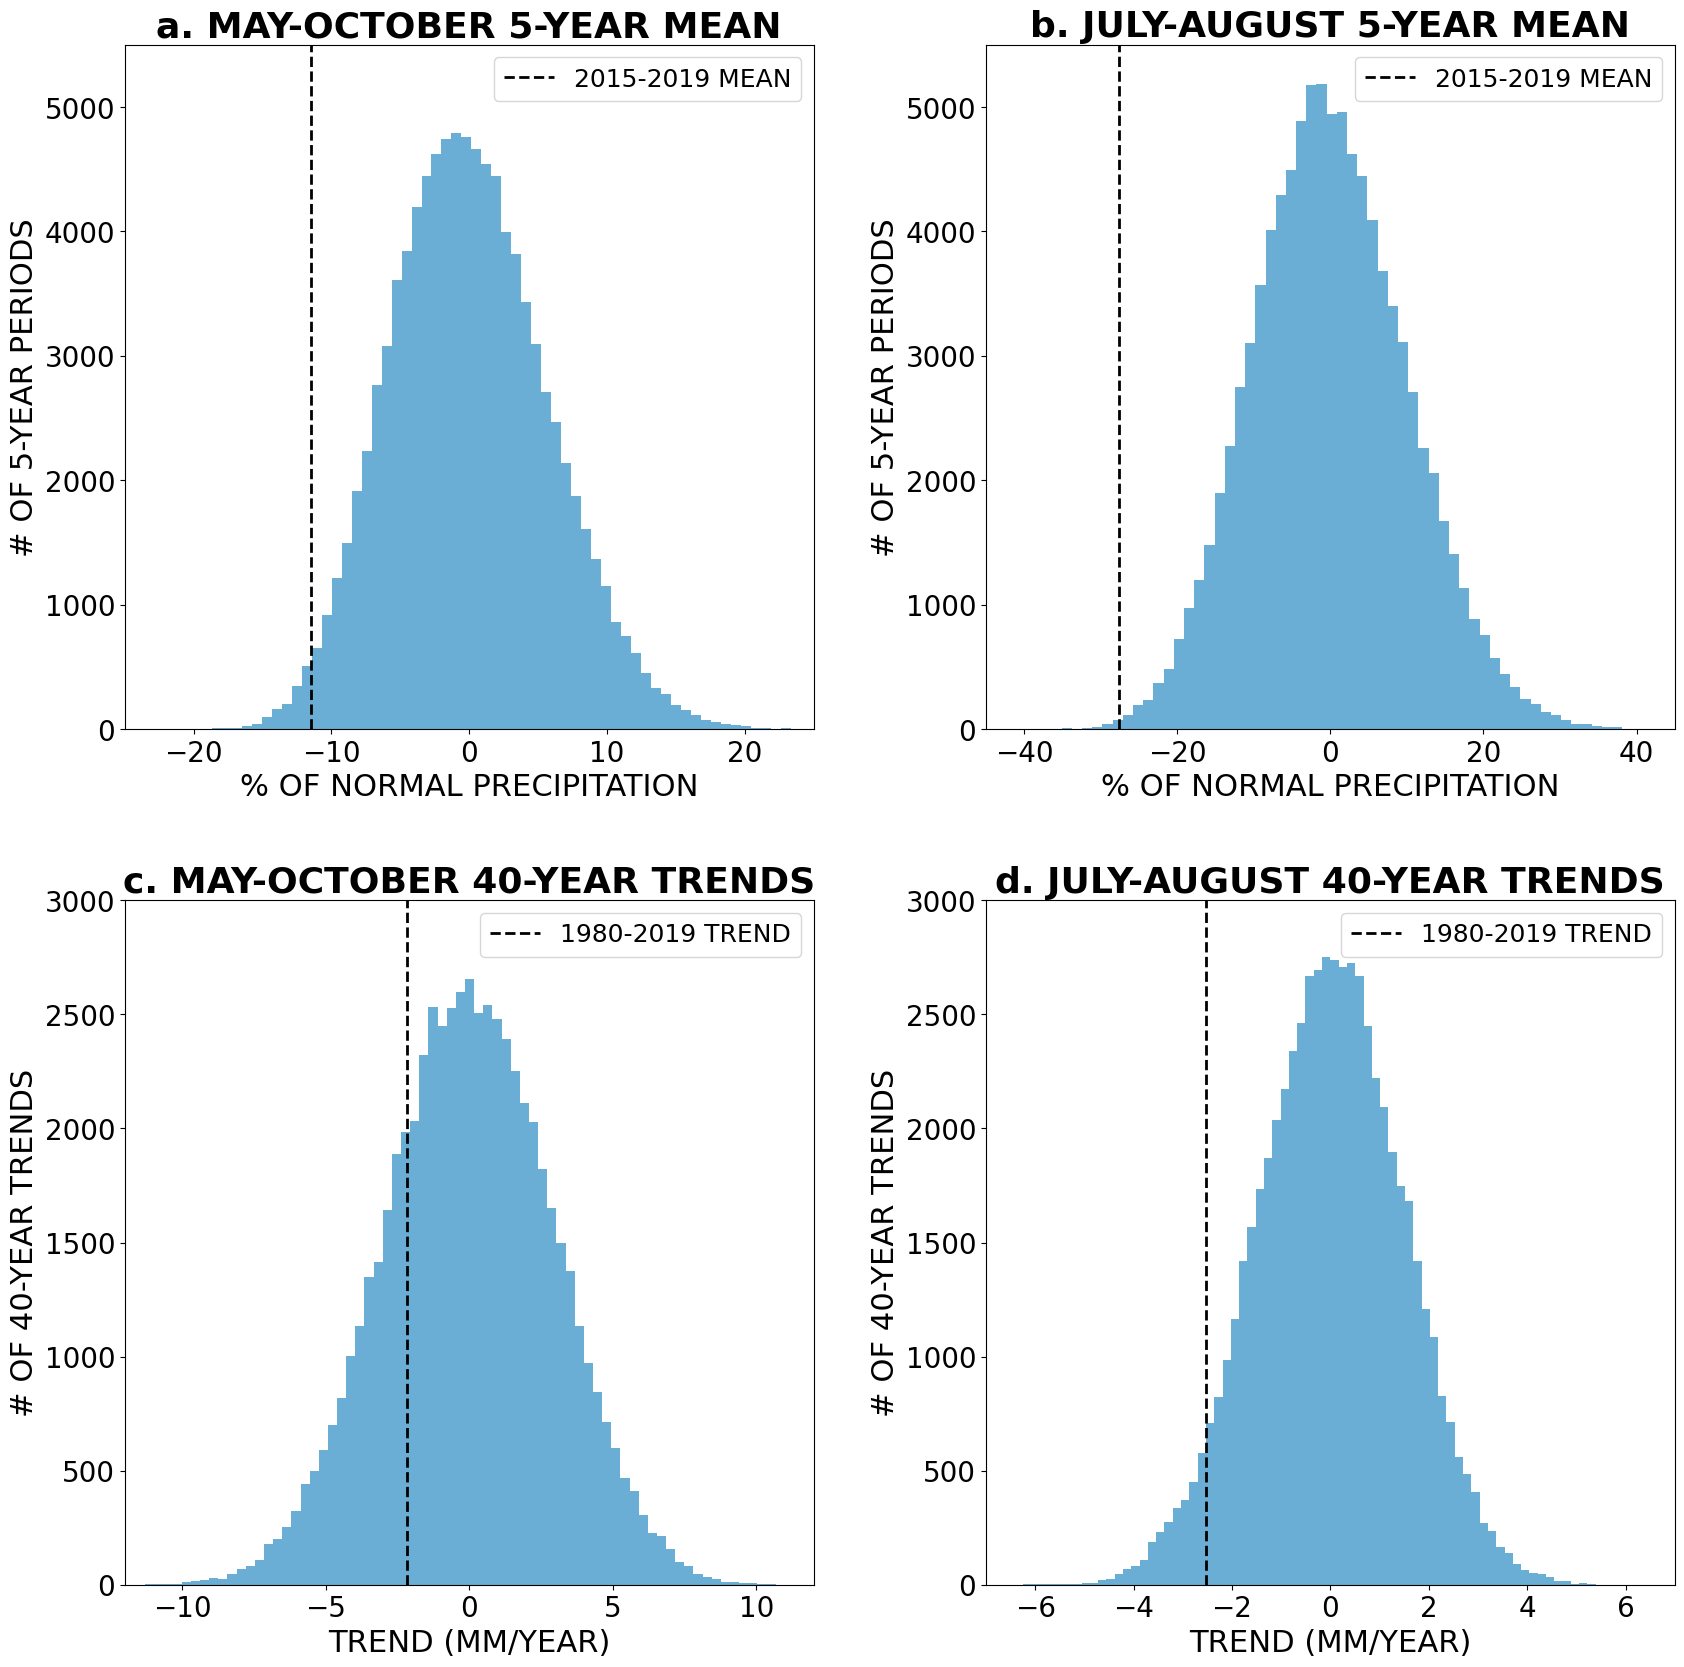

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [14]:
# Plot 5 year mean and trends of GS and JA

cmap = mpl.colormaps['Blues']
rgba_bins = cmap(0.5)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=[20,20])

ax1.hist(memTS_GS_5yr.flatten('F'),bins=61, color = rgba_bins)
ax1.axvline(reg5mov_GSObs.precip.values[-1],color = 'k',linestyle='--', linewidth = 2, label = '2015-2019 MEAN')
#ax1.text(-20.75, 5325, 'a.',fontsize=22,fontweight='bold')
ax1.set_xlim([-25, 25])
ax1.set_ylim([0, 5500])
ax1.set_xlabel("% OF NORMAL PRECIPITATION",fontsize=22)
ax1.set_ylabel("# OF 5-YEAR PERIODS",fontsize=22)
ax1.set_title('a. MAY-OCTOBER 5-YEAR MEAN',fontsize=26, fontweight = 'bold')
ax1.tick_params(labelsize=20)
ax1.legend(loc = 'upper right',fontsize=18)

ax2.hist(memTS_JA_5yr.flatten('F'),bins=61,color = rgba_bins)
ax2.axvline(reg5mov_JAObs.precip.values[-1],color = 'k',linestyle='--', linewidth = 2, label = '2015-2019 MEAN')
#ax2.text(-43.5, 5325, 'b.',fontsize=22,fontweight='bold')
ax2.sharey(ax1)
ax2.set_xlim([-45, 45])
ax2.set_xlabel("% OF NORMAL PRECIPITATION",fontsize=22)
ax2.set_ylabel("# OF 5-YEAR PERIODS",fontsize=22)
ax2.set_title('b. JULY-AUGUST 5-YEAR MEAN',fontsize=26, fontweight = 'bold')
ax2.tick_params(labelsize=20)
ax2.legend(loc = 'upper right',fontsize=18)

ax3.hist(memTrend_GS.flatten('F'),bins=69, color = rgba_bins)
ax3.axvline(mkGSout.slope,color = 'k',linestyle='--', linewidth = 2, label = '1980-2019 TREND')
#ax3.text(-11.25, 2900, 'c.',fontsize=22,fontweight='bold')
ax3.set_xlim([-12, 12])
ax3.set_ylim([0, 3000])
ax3.set_xlabel("TREND (MM/YEAR)",fontsize=22)
ax3.set_ylabel("# OF 40-YEAR TRENDS",fontsize=22)
ax3.set_title('c. MAY-OCTOBER 40-YEAR TRENDS',fontsize=26, fontweight = 'bold')
ax3.tick_params(labelsize=20)
ax3.legend(loc = 'upper right',fontsize=18)

ax4.hist(memTrend_JA.flatten('F'),bins=69, color = rgba_bins)
ax4.axvline(mkJAout.slope,color = 'k',linestyle='--', linewidth = 2, label = '1980-2019 TREND')
#ax4.text(-6.5, 2900, 'd.',fontsize=22,fontweight='bold')
ax4.sharey(ax3)
ax4.set_xlim([-7, 7])
ax4.set_xlabel("TREND (MM/YEAR)",fontsize=22)
ax4.set_ylabel("# OF 40-YEAR TRENDS",fontsize=22)
ax4.set_title('d. JULY-AUGUST 40-YEAR TRENDS',fontsize=26, fontweight = 'bold')
ax4.tick_params(labelsize=20)
ax4.legend(loc = 'upper right', fontsize=18)

plt.subplots_adjust(hspace=0.25, wspace=0.25)

plt.show()

fig.savefig('/glade/work/tanderson/DC_Drought/Figures/All40YrTrends_5YRMeans_GS_JA_CLLJV2.eps', format='eps', bbox_inches='tight')



In [15]:
# Spatial plots 

# Get 5 year means for each lat/lon
GSObs5yrAll = GSObs.rolling(year=5).mean()
JAObs5yrAll = JAObs.rolling(year=5).mean()

In [16]:
# Load GS OLE data (will want the 5-yr rolling mean data)
fnames = sorted(glob.glob('/glade/scratch/tanderson/obsLEAnalysis/GS5yr_v-noF_CLLJV2_v02_CentAm_Pr_05deg_blockNew/GS5yr_member????.nc'))
dsOLE = xr.open_mfdataset(fnames, concat_dim="year", combine="nested")
dsetOLE = dsOLE.precip

#Reshape, so that function can operate across the time dimension
reshapeOLE = dsetOLE.chunk({"year": -1, "lat": -1,"lon": -1})
print(reshapeOLE)

#Get 5th quantile
fifthGS = reshapeOLE.quantile(0.05, dim="year")
print(fifthGS)

# Determine where GS obs are < GS OLE 5th percentile
lons, lats = np.meshgrid(GSObs5yrAll.lon, GSObs5yrAll.lat)
sig_area_GS   = np.where(GSObs5yrAll.precip[-1,:,:]<fifthGS)

<xarray.DataArray 'precip' (year: 100000, lat: 14, lon: 20)>
dask.array<rechunk-merge, shape=(100000, 14, 20), dtype=float64, chunksize=(100000, 14, 20), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 17.75 17.25 16.75 16.25 ... 12.75 12.25 11.75 11.25
  * lon      (lon) float64 -92.75 -92.25 -91.75 -91.25 ... -84.25 -83.75 -83.25
  * year     (year) int64 1920 1921 1922 1923 1924 ... 2015 2016 2017 2018 2019
Attributes:
    description:  Member 0001 of the Observational Large Ensemble for precipi...
<xarray.DataArray 'precip' (lat: 14, lon: 20)>
dask.array<getitem, shape=(14, 20), dtype=float64, chunksize=(14, 20), chunktype=numpy.ndarray>
Coordinates:
  * lat       (lat) float64 17.75 17.25 16.75 16.25 ... 12.75 12.25 11.75 11.25
  * lon       (lon) float64 -92.75 -92.25 -91.75 -91.25 ... -84.25 -83.75 -83.25
    quantile  float64 0.05


In [17]:
# Load JA OLE data (will want the 5-yr rolling mean data)
fnames = sorted(glob.glob('/glade/scratch/tanderson/obsLEAnalysis/JA5yr_v-noF_CLLJV2_v02_CentAm_Pr_05deg_blockNew/JA5yr_member????.nc'))
dsOLE = xr.open_mfdataset(fnames, concat_dim="year", combine="nested")
dsetOLE = dsOLE.precip

#Reshape, so that function can operate across the time dimension
reshapeOLE = dsetOLE.chunk({"year": -1, "lat": -1,"lon": -1})
print(reshapeOLE)

#Get 5th quantile
fifthJA = reshapeOLE.quantile(0.05, dim="year")
print(fifthJA)

# Determine where GS obs are < GS OLE 5th percentile
sig_area_JA   = np.where(JAObs5yrAll.precip[-1,:,:]<fifthJA)

<xarray.DataArray 'precip' (year: 100000, lat: 14, lon: 20)>
dask.array<rechunk-merge, shape=(100000, 14, 20), dtype=float64, chunksize=(100000, 14, 20), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 17.75 17.25 16.75 16.25 ... 12.75 12.25 11.75 11.25
  * lon      (lon) float64 -92.75 -92.25 -91.75 -91.25 ... -84.25 -83.75 -83.25
  * year     (year) int64 1920 1921 1922 1923 1924 ... 2015 2016 2017 2018 2019
Attributes:
    description:  Member 0001 of the Observational Large Ensemble for precipi...
<xarray.DataArray 'precip' (lat: 14, lon: 20)>
dask.array<getitem, shape=(14, 20), dtype=float64, chunksize=(14, 20), chunktype=numpy.ndarray>
Coordinates:
  * lat       (lat) float64 17.75 17.25 16.75 16.25 ... 12.75 12.25 11.75 11.25
  * lon       (lon) float64 -92.75 -92.25 -91.75 -91.25 ... -84.25 -83.75 -83.25
    quantile  float64 0.05


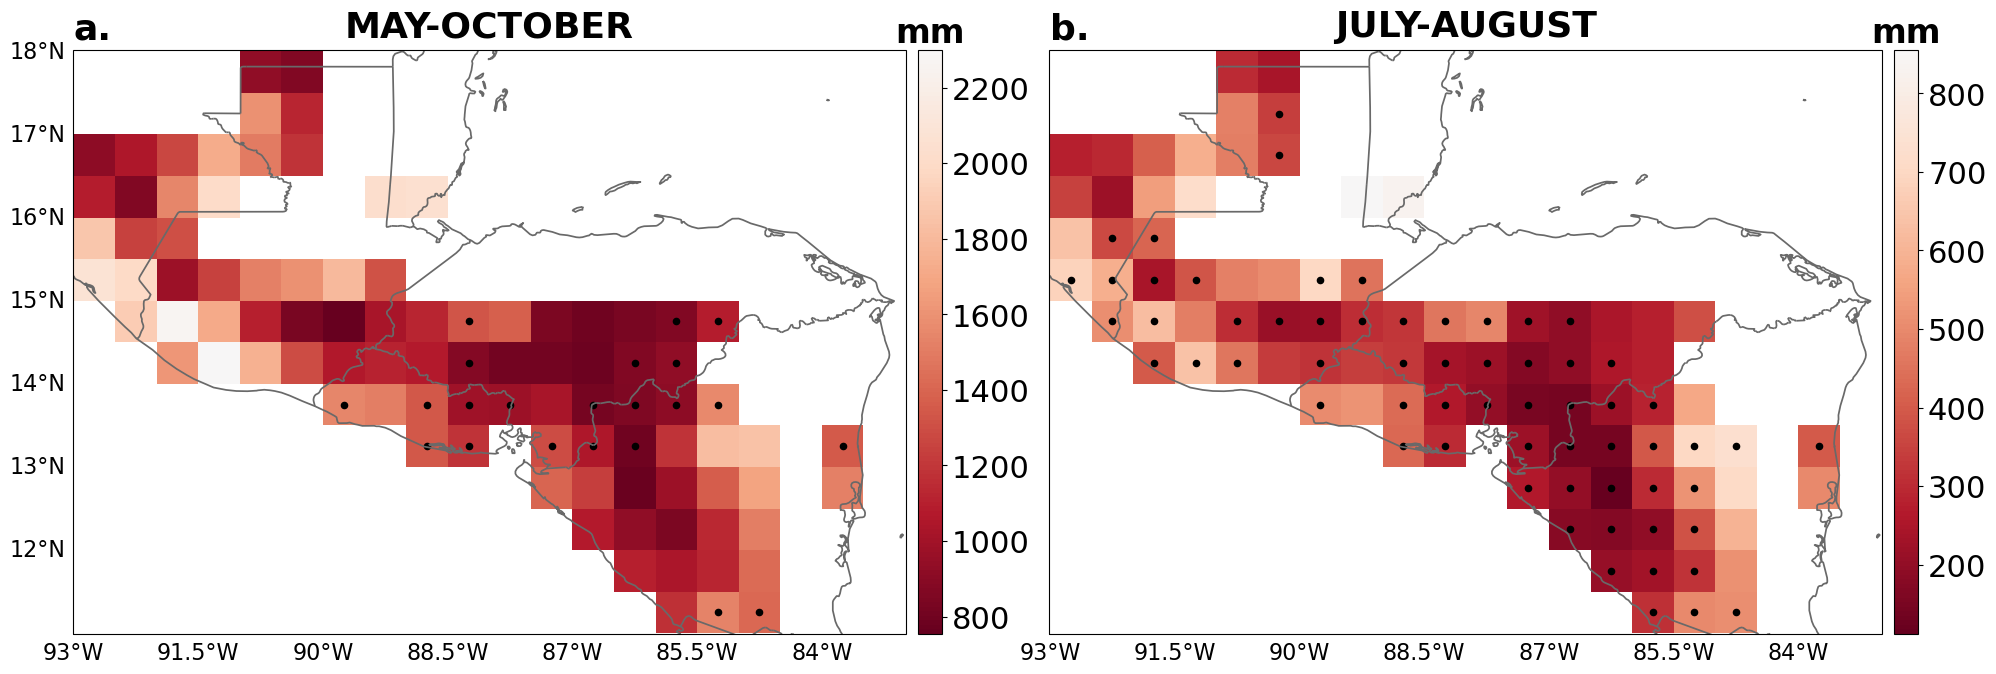

In [18]:
cmapR = cmr.get_sub_cmap('RdBu', 0, 0.5)

fig = plt.figure(figsize=[24,16])

ax1 = plt.subplot2grid((4,6),(0,0),rowspan = 2, colspan=3, projection=ccrs.PlateCarree(central_longitude = 0.0))
ax1.set_extent([-93.01, -82.99, 10.99, 18.01])
plt1= fifthGS.plot(ax=ax1, extend='max', cmap=cmapR,
                   transform=ccrs.PlateCarree(),  add_colorbar=False)
_ = ax1.scatter(lons[sig_area_GS], lats[sig_area_GS], marker = 'o', s = 20, c = 'k', alpha = 1, transform = ccrs.PlateCarree())
ax1.text(-93, 18.15, 'a.',fontsize=26,fontweight='bold')
ax1.add_feature(cf.COASTLINE, edgecolor='dimgray',linewidth=1.25)
ax1.add_feature(cf.BORDERS, edgecolor='dimgray',linewidth=1.25)
ax1.set_title(f'MAY-OCTOBER', fontweight = 'bold', fontsize=26,y=1.01)
gl = ax1.gridlines(crs=ccrs.PlateCarree(),draw_labels=True)
#gl.ylocator = mticker.FixedLocator([11,12,13,14,15,16,17,18])
#gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 16}
gl.ylabel_style = {'size': 16}
gl.xlines = False
gl.ylines = False
gl.top_labels = False
gl.right_labels = False
gl.bottom_labels = True

ax2 = plt.subplot2grid((4,6),(0,3),rowspan = 2, colspan=3, projection=ccrs.PlateCarree(central_longitude = 0.0))
ax2.set_extent([-93.01, -82.99, 10.99, 18.01])
plt2= fifthJA.plot(ax=ax2, extend='max', cmap=cmapR,
                   transform=ccrs.PlateCarree(), add_colorbar=False)
_ = ax2.scatter(lons[sig_area_JA], lats[sig_area_JA], marker = 'o', s = 20, c = 'k', alpha = 1, transform = ccrs.PlateCarree())
ax2.text(-93, 18.15, 'b.',fontsize=26,fontweight='bold')
ax2.add_feature(cf.COASTLINE, edgecolor='dimgray',linewidth=1.25)
ax2.add_feature(cf.BORDERS, edgecolor='dimgray',linewidth=1.25)
ax2.set_title(f'JULY-AUGUST', fontweight = 'bold', fontsize=26,y=1.01)
gl = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.xlabel_style = {'size': 16}
gl.ylabel_style = {'size': 16}
gl.xlines = False
gl.ylines = False
gl.top_labels = False
gl.right_labels = False
gl.left_labels = False
gl.bottom_labels = True

plt.subplots_adjust(hspace=0.25, wspace=0.4)

posn1 = ax1.get_position()
cbar_ax1 = fig.add_axes([0, 0, 0.1, 0.1])
cbar_ax1.set_position([posn1.x0 + posn1.width + 0.005, posn1.y0, 0.01, posn1.height])
cb=plt.colorbar(plt1,orientation='vertical', cax=cbar_ax1)
#cb.ax.locator_params(nbins=7)
cb.ax.set_title(label='mm',size=24, weight = 'bold')
cb.ax.tick_params(labelsize=22) 

posn2 = ax2.get_position()
cbar_ax2 = fig.add_axes([0, 0, 0.1, 0.1])
cbar_ax2.set_position([posn2.x0 + posn2.width + 0.005, posn2.y0, 0.01, posn2.height])
cb2=plt.colorbar(plt2,orientation='vertical', cax=cbar_ax2, ticks=[100, 200, 300, 400, 500, 600, 700, 800])
#cb2.ax.locator_params(nbins=7)
cb2.ax.set_title(label='mm',size=24, weight = 'bold')
cb2.ax.tick_params(labelsize=22) 
              
fig.savefig('/glade/work/tanderson/DC_Drought/Figures/5YrMean_5thPercentileMaps_ObsSig_GS_JA_CLLJV2.eps', format='eps', bbox_inches='tight')

In [19]:
# Get stats

# Number of sig grids
print(np.size(sig_area_GS,1))
print(np.size(sig_area_JA,1))

# Get total possible number of grids
allVals = GSanomPObs.precip[-1,:,:].values
print(np.size(allVals[~np.isnan(allVals)]))

# Percent of sig grids
print(np.size(sig_area_GS,1)/np.size(allVals[~np.isnan(allVals)])*100)
print(np.size(sig_area_JA,1)/np.size(allVals[~np.isnan(allVals)])*100)

22
63
93
23.655913978494624
67.74193548387096
